In [1]:
from pypower.api import loadcase, runopf, ppoption
from pypower.idx_brch import *
from pypower.idx_bus import *
from pypower.idx_gen import *
from pypower.idx_cost import *
from pypower.ext2int import ext2int
import oct2py
import numpy as np
from numpy import r_
import math
import os, sys
from tqdm import tqdm
from oct2py import Oct2Py
octave = Oct2Py()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
import shutil
import cvxpy as cp
from contextlib import contextmanager
import warnings
# suppress ComplexWarning
warnings.simplefilter("ignore", np.ComplexWarning)
# check for latex and configure matplotlib accordingly
if shutil.which('latex') is None:
    LATEX_AVAILABLE = False
else:
    LATEX_AVAILABLE = True
if LATEX_AVAILABLE:
    plt.rcParams['font.size'] = 14
    plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'

# to suppress output from functions    
@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout    

# user options 
MAX_BUS = 1000 # upper limit of number of buses in cases to be considered
RATE = 'A' # which line rating to use ('A','B','C')

In [2]:
# get all cases in current directory
current_directory = os.getcwd()+'/'
# current_directory = '/home/sbose/pglib-opf/' # for running on BEBOP
all_files_and_directories = os.listdir(current_directory)
case_files = [os.path.join(current_directory, f) for f in all_files_and_directories if f.endswith('.m') and os.path.isfile(os.path.join(current_directory, f))]

cases, casenames = [], []
cases_full, casenames_full = [], []
for cf in (t:=tqdm(case_files)):
    with suppress_stdout():
        octave.source(current_directory+os.path.basename(cf))
    cname = os.path.basename(cf).split('.')[0]
    num_buses = None
    # determine number of buses in the case from its name
    for ci in cname.split('_'):
        if 'case' in ci:
            num_buses = int(''.join([chr for chr in ci.replace('case','',1) if chr.isdigit()]))
    # fitler out cases with more buses than MAX_BUS
    if num_buses <= MAX_BUS:
        # convert to internal indexing
        case_correct_idx = ext2int(loadcase(octave.feval(cname)))
        # append
        cases.append(case_correct_idx)
        casenames.append(cname)
    t.set_description(cname)

  0%|                                                                                                                                                                                                                                      | 0/58 [00:00<?, ?it/s]

pglib_opf_case793_goc: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.60it/s]


Status of constraints:
        DISABLE_MODEL: False
        DISABLE_FLOWLIMS: False
        DISABLE_ANG: False
        DISABLE_SOCR: False
        DISABLE_BALANCE: False
        DISABLE_VLIMS: False
        DISABLE_GENLIMS: False
        


  0%|                                                                                                                                                                                                                                      | 0/21 [00:00<?, ?it/s]

Case pglib_opf_case60_c solved by MOSEK.


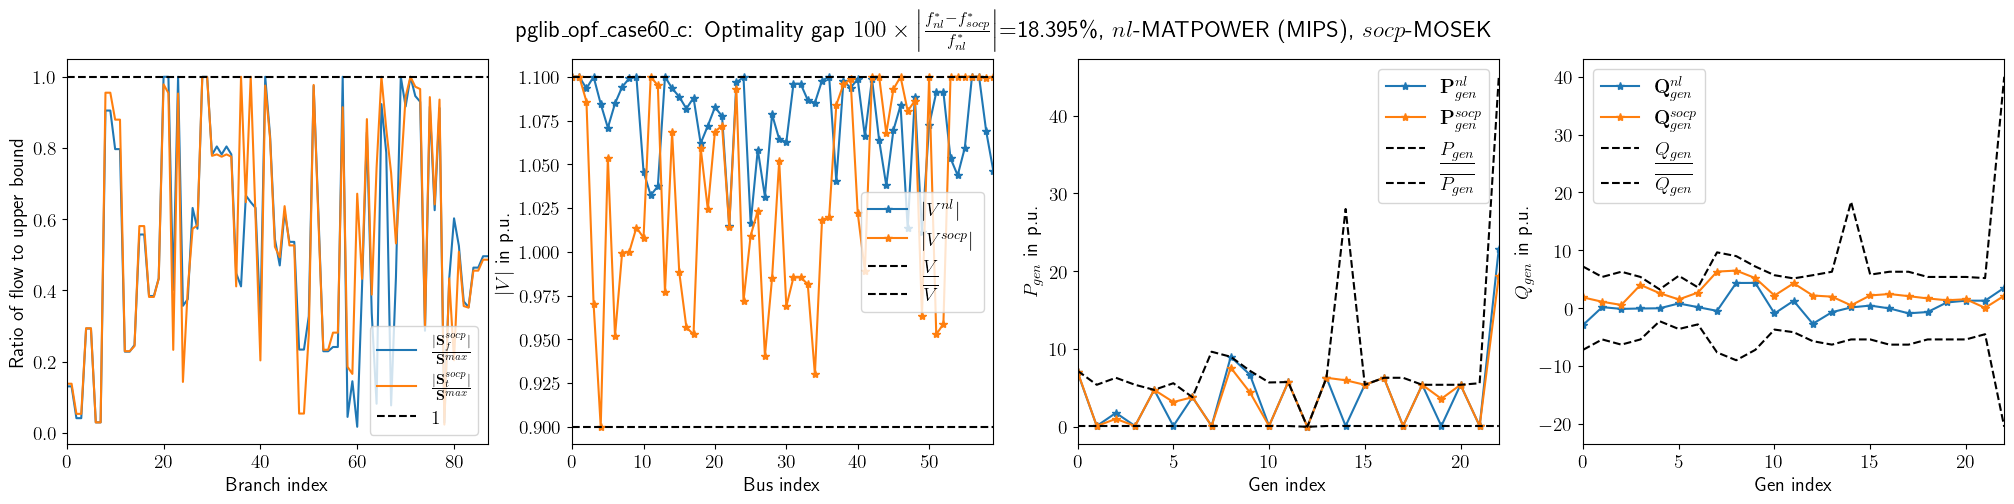

  5%|██████████▌                                                                                                                                                                                                                   | 1/21 [00:04<01:37,  4.89s/it]

Case pglib_opf_case39_epri solved by MOSEK.


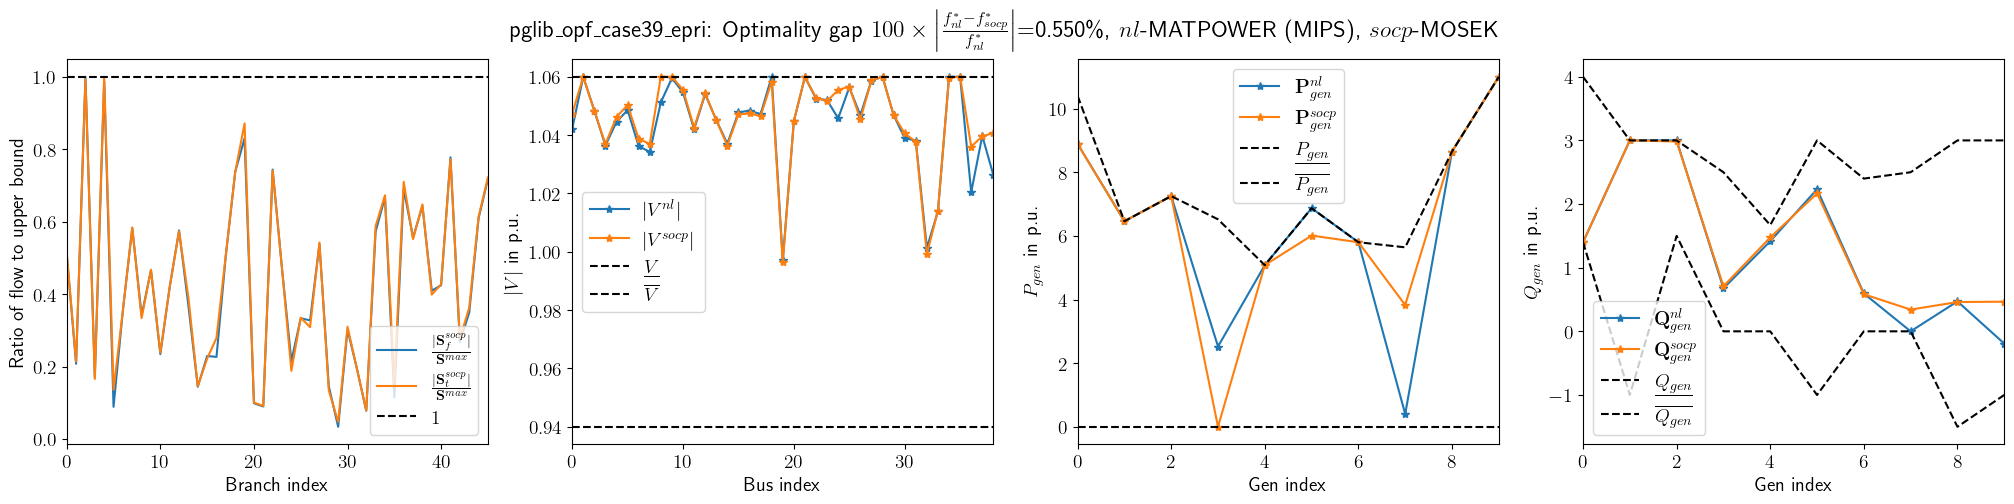

 10%|█████████████████████▏                                                                                                                                                                                                        | 2/21 [00:07<01:10,  3.69s/it]

Case pglib_opf_case240_pserc solved by MOSEK.


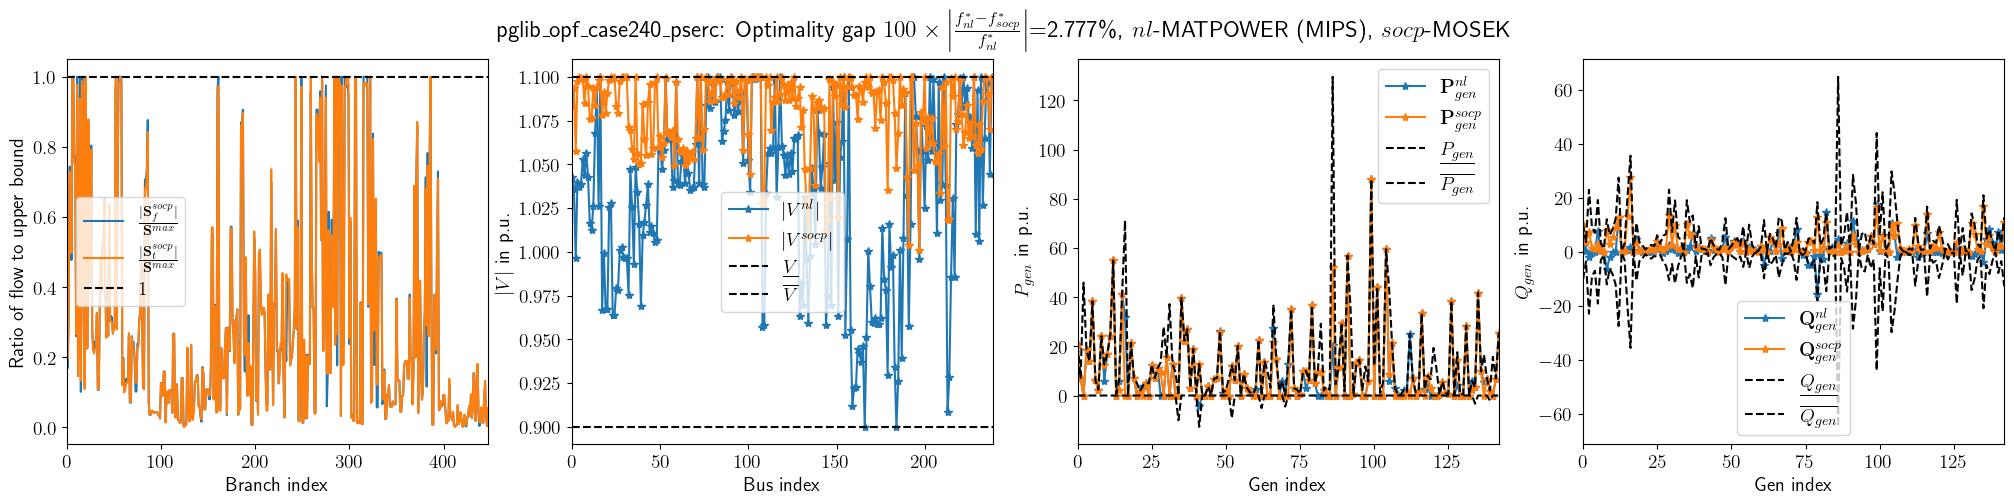

 14%|███████████████████████████████▎                                                                                                                                                                                           | 3/21 [08:47<1:11:47, 239.30s/it]

Case pglib_opf_case5_pjm solved by MOSEK.


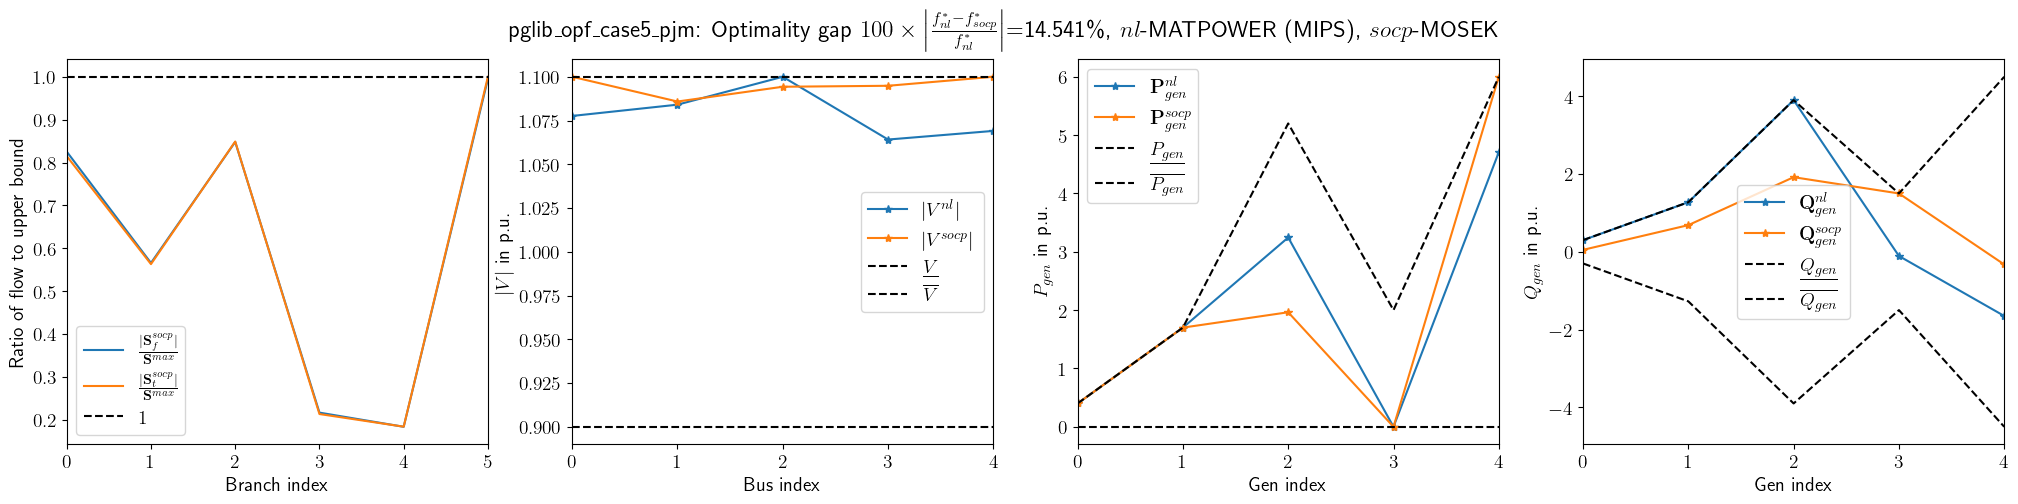

 19%|██████████████████████████████████████████                                                                                                                                                                                   | 4/21 [08:51<41:29, 146.42s/it]

: 

: 

: 

In [3]:
# CVXPY SWITCHES FOR ENABLING/DISABLING CONSTRAINTS
DISABLE_MODEL = False
DISABLE_FLOWLIMS = False
DISABLE_ANG = False
DISABLE_SOCR = False
DISABLE_BALANCE = False
DISABLE_VLIMS = False
DISABLE_GENLIMS = False
print(f'''Status of constraints:
        DISABLE_MODEL: {DISABLE_MODEL}
        DISABLE_FLOWLIMS: {DISABLE_FLOWLIMS}
        DISABLE_ANG: {DISABLE_ANG}
        DISABLE_SOCR: {DISABLE_SOCR}
        DISABLE_BALANCE: {DISABLE_BALANCE}
        DISABLE_VLIMS: {DISABLE_VLIMS}
        DISABLE_GENLIMS: {DISABLE_GENLIMS}
        ''')

# RECORDS FOR SOLVED AND UNSOLVED
solved, unsolved = 0,0

# FUNCTIONS TO COMPUTE ABSOLUTE VALUES # TEST
absobj = lambda x,y: cp.sum(cp.hstack([cp.abs(cp.real(x)),cp.abs(cp.imag(x)),cp.abs(cp.real(y)),cp.abs(cp.imag(y))]))

iterlist = [itm for itm in zip(casenames,cases)]
for cn,this_case in tqdm(iterlist):
    
    # LOAD DATA
    # baseMVA
    baseMVA = this_case['baseMVA']
    # bus data
    bus_list = this_case['bus'][:,BUS_I].astype(int)
    bus_vmin, bus_vmax = this_case['bus'][:,VMIN], this_case['bus'][:,VMAX]
    bus_pd, bus_qd = this_case['bus'][:,PD], this_case['bus'][:,QD]
    bus_gs, bus_bs = this_case['bus'][:,GS], this_case['bus'][:,BS]
    # branches
    from_bus = this_case['branch'][:,F_BUS]
    to_bus = this_case['branch'][:,T_BUS]
    br_r = this_case['branch'][:,BR_R]
    br_x = this_case['branch'][:,BR_X]
    br_b = this_case['branch'][:,BR_B]
    tap = this_case['branch'][:,TAP]
    shift = this_case['branch'][:,SHIFT]
    angmin, angmax = this_case['branch'][:,ANGMIN], this_case['branch'][:,ANGMAX]
    flow_lim = this_case['branch'][:,RATE_A]
    branch_list = [((f,t),(t,f),l) for f,t,l in zip(from_bus.astype(int),to_bus.astype(int),range(from_bus.size))] # forward and reversed graph
    # calculate flow limits
    choices = {'A':RATE_A,'B':RATE_B,'C':RATE_C}
    flow_lims = this_case['branch']
    # generators
    gen_to_bus = this_case['gen'][:,GEN_BUS]
    gen_mbase = this_case['gen'][:,MBASE]
    gen_pmax, gen_pmin = this_case['gen'][:,PMAX], this_case['gen'][:,PMIN]
    gen_qmax, gen_qmin = this_case['gen'][:,QMAX], this_case['gen'][:,QMIN]
    gen_cost = this_case['gencost'][:,COST:]
    
    # PRE-PROCESSING DATA
    # normalization to pu
    bus_pd, bus_qd, bus_gs, bus_bs, gen_pmax, gen_qmax, gen_pmin, gen_qmin, flow_lim = \
    bus_pd/baseMVA, bus_qd/baseMVA, bus_gs/baseMVA, bus_bs/baseMVA, \
    np.divide(gen_pmax,baseMVA), np.divide(gen_qmax,baseMVA), np.divide(gen_pmin,baseMVA), np.divide(gen_qmin,baseMVA), flow_lim/baseMVA
    # insert 1 in tap ratios
    tap = np.where(np.abs(tap)<1e-5,1.,tap)
    # convert angle limits to radians
    angmin, angmax = np.radians(angmin), np.radians(angmax)
    # convert 0 flow lims to large number
    flow_lim = np.where(np.abs(flow_lim)<1e-5,1e+3,flow_lim)
    
    # LAMBDA HELPER FUNCTIONS
    gen_on_bus = lambda i: np.where(gen_to_bus == i)[0] # return list og gens attached to bus
    out_lines = lambda i: np.array([w[2] if w[0][0]==i else np.inf for w in branch_list])[np.array([w[2] if w[0][0]==i else np.inf for w in branch_list])!=np.inf].astype(int)
    in_lines = lambda i: np.array([w[2] if w[0][1]==i else np.inf for w in branch_list])[np.array([w[2] if w[0][1]==i else np.inf for w in branch_list])!=np.inf].astype(int)
    
    # NUMBER OF DIFFERENT ELEMENTS
    n_bus = len(bus_list)
    n_branch = len(branch_list)
    n_gen = len(gen_to_bus)
    
    # CVXPY VARIABLES
    Sf = cp.Variable(n_branch,complex=True,name='Sf') # p.u.
    St = cp.Variable(n_branch,complex=True,name='St') # p.u.
    Sgen = cp.Variable(n_gen,complex=True,name='Sgen') # p.u.
    U = cp.Variable(n_bus,name='U') # p.u.
    W = cp.Variable(n_branch,complex=True,name='W') # p.u.
    
    # PARAMETERS
    params = {
        'Pd' : cp.Parameter(bus_pd.size,name='pd'),
        'Qd' : cp.Parameter(bus_qd.size,name='qd'),
        'F' : cp.Parameter(flow_lim.size,name='f'),
        'Pgmax' : cp.Parameter(gen_pmax.size,name='pmax'),
        'Pgmin' : cp.Parameter(gen_pmin.size,name='pmin'),
        'Qgmax' : cp.Parameter(gen_qmax.size,name='qmax'),
        'Qgmin' : cp.Parameter(gen_qmin.size,name='qmin'),
        'Angmin' : cp.Parameter(angmin.size,name='amin'),
        'Angmax' : cp.Parameter(angmax.size,name='amax'),
        'Vmin' : cp.Parameter(bus_vmin.size,name='vmin'),
        'Vmax' : cp.Parameter(bus_vmax.size,name='vmax')
    }
    
    # PARAMETER VALUES
    params['Pd'].value = bus_pd
    params['Qd'].value = bus_qd
    params['F'].value = flow_lim
    params['Pgmax'].value = gen_pmax
    params['Pgmin'].value = gen_pmin
    params['Qgmax'].value = gen_qmax
    params['Qgmin'].value = gen_qmin
    params['Angmin'].value = np.tan(angmin)
    params['Angmax'].value = np.tan(angmax)
    params['Vmin'].value = np.square(bus_vmin)
    params['Vmax'].value = np.square(bus_vmax)
    
    # CVXPY CONSTRAINTS
    constr = []
    # bus constraints (non-balance)
    for busid in bus_list:
        if not DISABLE_VLIMS:
            constr.append(U[busid] <= params['Vmax'][busid])
            constr.append(U[busid] >= params['Vmin'][busid])
    # branch constraints
    for br in branch_list:
        brf, brr, brid = br
        yl, b = 1 / (br_r[brid] + 1j * br_x[brid]), br_b[brid]
        tl = tap[brid] * (math.cos(shift[brid]) + 1j * math.sin(shift[brid]))
        yff, ytt, yft, ytf = (yl + 1j * (b/2)) / (tl*tl.conjugate()) , (yl + 1j * (b/2)), - yl / tl.conjugate(), -yl / tl
        if not DISABLE_MODEL:
            # forward and reverse flows
            frm, to = brf[0], brf[1]
            constr.append(Sf[brid] == yff.conjugate()*U[frm] + yft.conjugate()*W[brid])
            constr.append(St[brid] == ytt.conjugate()*U[to] + ytf.conjugate()*cp.conj(W[brid]))
        if not DISABLE_FLOWLIMS:
            # flow limits
            constr.append(cp.abs(Sf[brid]) <= params['F'][brid])
            constr.append(cp.abs(St[brid]) <= params['F'][brid])
        if not DISABLE_ANG:
            # angle limits
            constr.append(cp.imag(W[brid]) <= params['Angmax'][brid] * cp.real(W[brid]))
            constr.append(cp.imag(W[brid]) >= params['Angmin'][brid] * cp.real(W[brid]))
        if not DISABLE_SOCR:
            # second order cones
            frm, to = brf[0], brf[1]
            constr.append(cp.norm(cp.hstack([U[frm]-U[to],2*cp.real(W[brid]),2*cp.imag(W[brid])]),2) <= U[frm]+U[to])
    # generator constraints
    if not DISABLE_GENLIMS:
        for gidx in range(n_gen):
            constr.append(cp.real(Sgen[gidx]) <= params['Pgmax'][gidx])
            constr.append(cp.real(Sgen[gidx]) >= params['Pgmin'][gidx])
            constr.append(cp.imag(Sgen[gidx]) <= params['Qgmax'][gidx])
            constr.append(cp.imag(Sgen[gidx]) >= params['Qgmin'][gidx])
    else:
        constr.append(cp.real(Sgen) >= params['Pgmin'])
    # bus constraints (balance)
    for busid in bus_list:
        Sd = params['Pd'][busid] + 1j * params['Qd'][busid]
        gens = gen_on_bus(busid)
        Sgen_total = cp.sum([Sgen[gid] for gid in gens]) if gens.size > 0 else 0
        Sf_total = cp.sum([Sf[brid] for brid in out_lines(busid)]) if out_lines(busid).size >0 else 0
        St_total = cp.sum([St[brid] for brid in in_lines(busid)]) if in_lines(busid).size >0 else 0
        Ys = bus_bs[busid] - 1j * bus_gs[busid]
        if not DISABLE_BALANCE:
            constr.append(Sgen_total - Sd - Ys*U[busid] == Sf_total + St_total)
    # create objective
    obj_fn = 0
    for gidx in range(n_gen):
        if np.abs(gen_cost[gidx,0]) > 1e-5: # quadratic cost
            obj_fn = obj_fn + gen_cost[gidx,0]*cp.power(cp.real(Sgen[gidx]),2)
        if np.abs(gen_cost[gidx,1]) > 1e-5: # linear cost
            obj_fn = obj_fn + gen_cost[gidx,1]*cp.real(Sgen[gidx])
        if np.abs(gen_cost[gidx,2]) > 1e-5: # constant cost
            obj_fn = obj_fn + gen_cost[gidx,2]
    # create problem
    prob = cp.Problem(cp.Minimize(obj_fn),constr)
    # # check if DPP COMPLIANT
    # print(f"Problem {cn}'s DPP status is: {prob.is_dcp(dpp=True)}")
    # solve problem and record results
    solvers = ['MOSEK','GUROBI','SCS'] # choice of solvers installed on cvxpy
    for solver in solvers:
        try:
            # use 'reoptimize' kw for gurobi
            kwargs = {'verbose':False,'reoptimize':True} if solver=='GUROBI' else {'verbose':False}
            prob.solve(solver=solver,**kwargs)
            if prob.status not in ['infeasible','unbounded']:
                print(f"Case {cn} solved by {solver}.")
                SOLVED = True
                SOLVER = solver
                break
            else:
                print(f"Case {cn} not solved by {solver}, status is {prob.status}.")
                SOLVED = False
        except Exception as e:
            print(f"Case {cn} not solved by {solver}, exception is {e}.")
            SOLVED = False
    # display results accordingly
    if SOLVED:
        solved += 1
        # load stored MATPOWER solution (referred to as 'nonlinear')
        with open(f"{current_directory}/{cn}_solved.pkl","rb") as file:
            obj = pickle.load(file)
            obj = ext2int(obj)
        # calculate soc objective in natural units
        soc_pg, nl_pg = Sgen.value.real, obj['gen'][:,PG] / baseMVA
        obj_soc, obj_nl = 0, 0
        for gidx in range(n_gen):
            if np.abs(gen_cost[gidx,0]) > 1e-5: # quadratic cost
                obj_soc = obj_soc + gen_cost[gidx,0]*soc_pg[gidx]**2
                obj_nl = obj_nl + gen_cost[gidx,0]*nl_pg[gidx]**2
            if np.abs(gen_cost[gidx,1]) > 1e-5: # linear cost
                obj_soc = obj_soc + gen_cost[gidx,1]*soc_pg[gidx]
                obj_nl = obj_nl + gen_cost[gidx,1]*nl_pg[gidx]
            if np.abs(gen_cost[gidx,2]) > 1e-5: # constant cost
                obj_soc = obj_soc + gen_cost[gidx,2]
                obj_nl = obj_nl + gen_cost[gidx,2]
        # compute gap
        gap = 100 * np.abs(obj_nl - obj_soc) / np.abs(obj_nl)
        # plot
        fig, axs = plt.subplots(1, 4, figsize=(25, 5)) # common axes
        # how well does socp relaxation respect line flow constraints
        axs[0].plot((np.abs(Sf.value) / flow_lim), label=r'$\frac{|\mathbf{S}_f^{socp}|}{\mathbf{S}^{max}}$')
        axs[0].plot((np.abs(St.value) / flow_lim), label=r'$\frac{|\mathbf{S}_t^{socp}|}{\mathbf{S}^{max}}$')
        axs[0].plot(np.ones_like(Sf.value),'k--',label=r'$1$')
        axs[0].legend()
        axs[0].set_xlabel('Branch index')
        axs[0].set_ylabel('Ratio of flow to upper bound')
        axs[0].set_xlim([0,Sf.value.size-1])
        # voltage limits
        vmag_nl, vmag_socp = obj['bus'][:,VM], np.sqrt(U.value)
        axs[1].plot(vmag_nl,'*-',label=r'$|V^{nl}|$')
        axs[1].plot(vmag_socp,'*-',label=r'$|V^{socp}|$')
        axs[1].plot(bus_vmin,'k--',label=r'$\underline{V}$')
        axs[1].plot(bus_vmax,'k--',label=r'$\overline{V}$')
        axs[1].legend()
        axs[1].set_xlabel('Bus index')
        axs[1].set_ylabel(r'$|V|$ in p.u.')
        axs[1].set_xlim([0,n_bus-1])
        # real power
        pg_nl, pg_socp = obj['gen'][:,PG] / obj['baseMVA'], Sgen.value.real
        axs[2].plot(pg_nl,'*-',label=r'$\mathbf{P}^{nl}_{gen}$')
        axs[2].plot(pg_socp,'*-',label=r'$\mathbf{P}^{socp}_{gen}$')
        axs[2].plot(gen_pmin,'k--',label=r'$\underline{P_{gen}}$')
        axs[2].plot(gen_pmax,'k--',label=r'$\overline{P_{gen}}$')
        axs[2].legend()
        axs[2].set_xlabel('Gen index')
        axs[2].set_ylabel(r'$P_{gen}$ in p.u.')
        axs[2].set_xlim([0,pg_nl.size-1])
        # reactive power
        qg_nl, qg_socp = obj['gen'][:,QG] / obj['baseMVA'], Sgen.value.imag
        axs[3].plot(qg_nl,'*-',label=r'$\mathbf{Q}^{nl}_{gen}$')
        axs[3].plot(qg_socp,'*-',label=r'$\mathbf{Q}^{socp}_{gen}$')
        axs[3].plot(gen_qmin,'k--',label=r'$\underline{Q_{gen}}$')
        axs[3].plot(gen_qmax,'k--',label=r'$\overline{Q_{gen}}$')
        axs[3].legend()
        axs[3].set_xlabel('Gen index')
        axs[3].set_ylabel(r'$Q_{gen}$ in p.u.')
        axs[3].set_xlim([0,qg_nl.size-1])
        # title
        fig.suptitle(r"%s: Optimality gap $100\times\left\lvert\frac{f^*_{nl}-f^*_{socp}}{f^*_{nl}}\right\rvert$=%s\%s, $nl$-MATPOWER (MIPS), $socp$-%s"%(f"{cn}",f"{gap:.3f}","%",SOLVER))
        plt.savefig(f'{cn}_results.pdf',format='pdf',bbox_inches='tight')
        plt.show()
    else:
        unsolved += 1
    # break

# DISPLAY OUTCOME
print(f"Solved {100*solved/(solved+unsolved)} percent of cases.")